In [2]:
!pip install pandas
!pip install xlrd
!pip install 'pandas-profiling==2.8.0'
!pip install seaborn
from scipy.stats import chi2
from scipy.stats import chi2_contingency

You should consider upgrading via the '/home/esteban/Documentos/cda/jupyter/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/esteban/Documentos/cda/jupyter/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/home/esteban/Documentos/cda/jupyter/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/esteban/Documentos/cda/jupyter/bin/python -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import seaborn as sns
from pandas_profiling import ProfileReport
from matplotlib import pyplot

sns.set_style(style="whitegrid")

In [4]:
df_hurtos = pd.concat([
    pd.read_excel('data/hurto-de-automotores-2017_0.xls', skiprows=9),
    pd.read_excel('data/hurto-de-automotores-2018_0.xls', skiprows=8),
    pd.read_excel('data/hurto-de-automotores-2018_1.xls', skiprows=9),
    pd.read_excel('data/hurto-de-automotores-2019_0.xls', skiprows=8)
])

# Limpieza

In [5]:
# Correción de valores de edad y cantidad. 
# Edad -1 representa que no se conoce la edad del individuo
# Cantidad 1000 se borra en un paso posterior.
df_hurtos['Edad'] = df_hurtos['Edad'].fillna('-1')
df_hurtos['Edad'] = df_hurtos['Edad'].astype(str)
df_hurtos = df_hurtos[df_hurtos['Edad'] != '-']
df_hurtos = df_hurtos[df_hurtos['Edad'] != '-1']

# Corrección de tipos.
cols_str = [
    'Fecha','Hora', 'Departamento', 'Municipio', 'Día', 'Barrio', 'Zona', 'Clase de sitio', 
    'Arma empleada', 'Móvil Agresor', 'Móvil Victima', 'Sexo', 'Estado civil' ,
    'País de nacimiento','Clase de empleado', 'Profesión', 'Escolaridad', 'Código DANE', 'CLASE',
    'MARCA', 'LINEA', 'MODELO', 'COLOR']
for col in cols_str:
    df_hurtos[col] = df_hurtos[col].astype(str)

df_hurtos['Edad'] = df_hurtos['Edad'].astype('int64')

# Remoción de duplicados
df_hurtos.drop_duplicates(inplace=True)

# Remoción de valores atípicos/outliers. 
# 1. Constantes
df_hurtos.drop(columns=['Cantidad', 'Profesión', 'Zona', 'Barrio', 'País de nacimiento'], inplace=True)
# 2. Registros con edad mayor a 110
df_hurtos = df_hurtos[df_hurtos['Edad'] < 110]

# Creación de nuevas columnas
df_hurtos['Fecha'] = df_hurtos['Fecha'].apply(lambda x: x[:11])
df_hurtos['Mes'] = df_hurtos['Fecha'].apply(lambda x: x[5:7])

# Categorización de la variable Hora
def hora_to_cat(hora):
    if hora == 'na':
        return "No_especificada"
    hora = int(hora)

    if hora > 0 and hora <= 4:
        return '(00-04]'
    if hora > 4 and hora <= 8:
        return '(04-08]'
    if hora > 8 and hora <= 12:
        return '(08-12]'
    if hora > 12 and hora <= 16:
        return '(12-16)'
    if hora > 16 and hora <= 20:
        return '(16-20]'
    if hora == 0 or hora > 20:
        return '(20-24]'
df_hurtos['Hora_Cat'] = df_hurtos['Hora'].apply(lambda hora: hora_to_cat(hora[:2]))


In [6]:
colores_dict = {
    'ABANO': 'BLANCO', 'BEIGE': 'BLANCO', 'BLANCO': 'BLANCO', 'BLANCO Y VERDE': 'BLANCO', 'CHAMPAÑA': 'BLANCO', 'CREMA': 'BLANCO', 'MARFIL': 'BLANCO', 'PERLA': 'BLANCO',
    'SAHARA': 'BLANCO', 

    'ACEITUNA': 'VERDE', 'BOSQUE': 'VERDE', 'JADE': 'VERDE', 'LIMON': 'VERDE', 'VERDE': 'VERDE', 'VERDE OSCURO': 'VERDE', 

    'BAMBOO': 'CAFE','CAFE': 'CAFE', 'CARAMELO': 'CAFE', 'HABANO': 'CAFE', 'MARRON': 'CAFE', 'PARDO LAGUNA': 'CAFE', 'ROBLE': 'CAFE', 'TABACO': 'CAFE', 'TERRANOVA': 'CAFE',

    'ACERO': 'GRIS', 'CENIZA GRAFITO': 'GRIS', 'CROMADO': 'GRIS', 'ESTRATO DE PERLA':'GRIS', 'GRAFITO': 'GRIS', 'GRIS': 'GRIS', 'GRIS PLATINO': 'GRIS', 'PLATA': 'GRIS',
    'PLATA NIQUEL': 'GRIS','PLATEADO': 'GRIS', 'PLATINO': 'GRIS', 'STRATO PLATA': 'GRIS', 'SILICE TORNADO': 'GRIS', 'TOLEDANO': 'GRIS',

    'ACUARELA': 'AZUL', 'AZUL': 'AZUL', 'AZUL BAHIA': 'AZUL', 'AZUL BALTICO': 'AZUL', 'AZUL CIELO': 'AZUL', 'AZUL LAGUNA': 'AZUL', 'AZUL LISBOA' : 'AZUL', 
    'AZUL MEDIO': 'AZUL', 'AZUL Y BLANCO': 'AZUL', 'AZUL ZAFIRO': 'AZUL', 'CELESTE': 'AZUL', 'CIELO': 'AZUL', 'TURQUEZA': 'AZUL', 'ZAFIRO': 'AZUL',

    'BRONCE': 'NARANJA', 'COBRE': 'NARANJA', 'FUEGO': 'NARANJA', 'LADRILLO': 'NARANJA', 'MANDARINA': 'NARANJA', 'NARANJA': 'NARANJA', 'OTOÑAL': 'NARANJA', 
    'ZAPOTE': 'NARANJA',

    'BRUMA': 'MORADO', 'FIRMAMENTO': 'MORADO', 'IMPERIAL': 'MORADO', 'LILA': 'MORADO', 'MORADO CORDOBES': 'MORADO', 'VINOTINTO': 'MORADO', 'VIOLETA': 'MORADO', 

    'CEREZA': 'ROJO', 'ROJO': 'ROJO','ROJO - BLANCO': 'ROJO','ROJO-MARRON-ROYAL': 'ROJO','ROJO-VERDE': 'ROJO', 'TERRACOTA': 'ROJO',

    'NEGRO': 'NEGRO', 'NEGRO GRAFITO': 'NEGRO', 'NEGRO Y BLANCO': 'NEGRO', 'NEGRO Y NIQUEL': 'NEGRO',  

    'CINZA EJECUTIVO': 'OTRO', 'CLASICO': 'OTRO', 'COLONIAL': 'OTRO', 'METALIZADO': 'OTRO', 'NO REPORTADO': 'OTRO', 'PRIMER': 'OTRO', 'QUARZO': 'OTRO', 
    'SAFARI': 'OTRO', 'VARIOS COLORES': 'OTRO', '-': 'OTRO',

    'AMARILLO': 'AMARILLO', 'AMARILLO TRANSITO': 'AMARILLO', 'AMARILLO Y BLANCO': 'AMARILLO', 'AMARILLO Y NEGRO': 'AMARILLO', 'DORADO': 'AMARILLO', 
    'MOSTAZA': 'AMARILLO', 'ORO': 'AMARILLO'
}

In [7]:
# Agrupación de colores
df_hurtos['COLOR'] = df_hurtos['COLOR'].apply(lambda c: colores_dict[c])

In [8]:
report = ProfileReport(df_hurtos)
report.to_file('Perfilamiento de hurto a vehículos.html')

/home/esteban/Documentos/cda/jupyter/lib/python3.8/site-packages/pandas_profiling/visualisation/plot.py:154: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu"))
  cmap.set_bad(cmap_bad)


In [9]:
df_hurtos.head()

,Fecha,Departamento,Municipio,Día,Hora,Clase de sitio,Arma empleada,Móvil Agresor,Móvil Victima,Edad,...,Clase de empleado,Escolaridad,Código DANE,CLASE,MARCA,LINEA,MODELO,COLOR,Mes,Hora_Cat
1,2017-01-01,CUNDINAMARCA,BOGOTÁ D.C. (CT),Domingo,00:00:00,VIAS PUBLICAS,SIN EMPLEO DE ARMAS,A PIE,A PIE,18,...,EMPLEADO PARTICULAR,PRIMARIA,11001000.0,AUTOMOVIL,NO REPORTADO,LINEA STANDARD,2015,AZUL,01,(20-24]
2,2017-01-01,MAGDALENA,CIÉNAGA,Domingo,00:00:00,CASAS DE HABITACION,SIN EMPLEO DE ARMAS,A PIE,A PIE,37,...,EMPLEADO PARTICULAR,SECUNDARIA,47189000.0,BUSETA,NO REPORTADO,LINEA STANDARD,2000,VERDE,01,(20-24]
3,2017-01-01,TOLIMA,IBAGUÉ (CT),Domingo,00:00:00,VIAS PUBLICAS,SIN EMPLEO DE ARMAS,A PIE,A PIE,52,...,EMPLEADO PARTICULAR,PRIMARIA,73001000.0,AUTOMOVIL,CHEVROLET,SPARK,2008,AMARILLO,01,(20-24]
4,2017-01-01,VALLE,CALI (CT),Domingo,08:00:00,VIAS PUBLICAS,LLAVE MAESTRA,A PIE,A PIE,42,...,EMPLEADO PARTICULAR,SUPERIOR,76001000.0,AUTOMOVIL,CHEVROLET,SPRINT,1992,ROJO,01,(04-08]
5,2017-01-01,VALLE,CALI (CT),Domingo,08:00:00,VIAS PUBLICAS,LLAVE MAESTRA,A PIE,A PIE,40,...,EMPLEADO PARTICULAR,TECNICO,76001000.0,AUTOMOVIL,RENAULT,R 9,1995,ROJO,01,(04-08]


In [10]:
# Hora, Departamento
df_hurtos_hora_detartamento_c = pd.crosstab(index=df_hurtos.Departamento,columns=df_hurtos["Hora_Cat"],margins=True)
df_hurtos_top = df_hurtos_hora_detartamento_c.sort_values("All", ascending=False).head(11)
df_hurtos_top

Hora_Cat,(00-04],(04-08],(08-12],(12-16),(16-20],(20-24],All
Departamento,,,,,,,
All,3689,4503,5753,5523,7448,9631,36547
CUNDINAMARCA,1505,1052,1883,1746,3121,5220,14527
VALLE,409,1192,1605,1629,1832,1388,8055
ANTIOQUIA,541,1035,925,952,1051,1248,5752
CAUCA,183,211,270,196,257,280,1397
ATLÁNTICO,212,237,171,176,199,282,1277
NARIÑO,151,90,115,91,147,196,790
GUAJIRA,114,127,122,142,149,131,785
CESAR,100,119,132,146,115,156,768


In [11]:
df_hurtos_cross_div = df_hurtos_top.div(df_hurtos_top.All, axis=0)
df_hurtos_cross_div = df_hurtos_cross_div.drop(['All'], axis=1).drop('All', axis=0)

<AxesSubplot:xlabel='Departamento'>

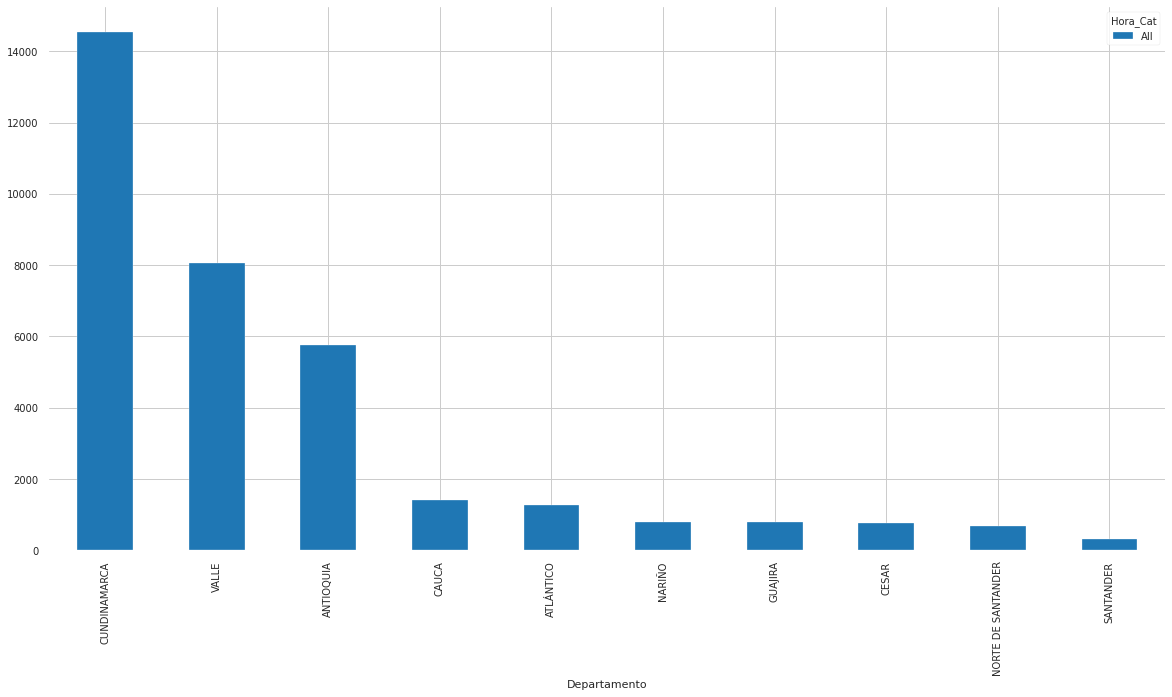

In [12]:
df_hurtos_top[["All"]].drop('All', axis=0).plot(kind='bar',figsize=(20,10),legend=True)

<AxesSubplot:xlabel='Departamento'>

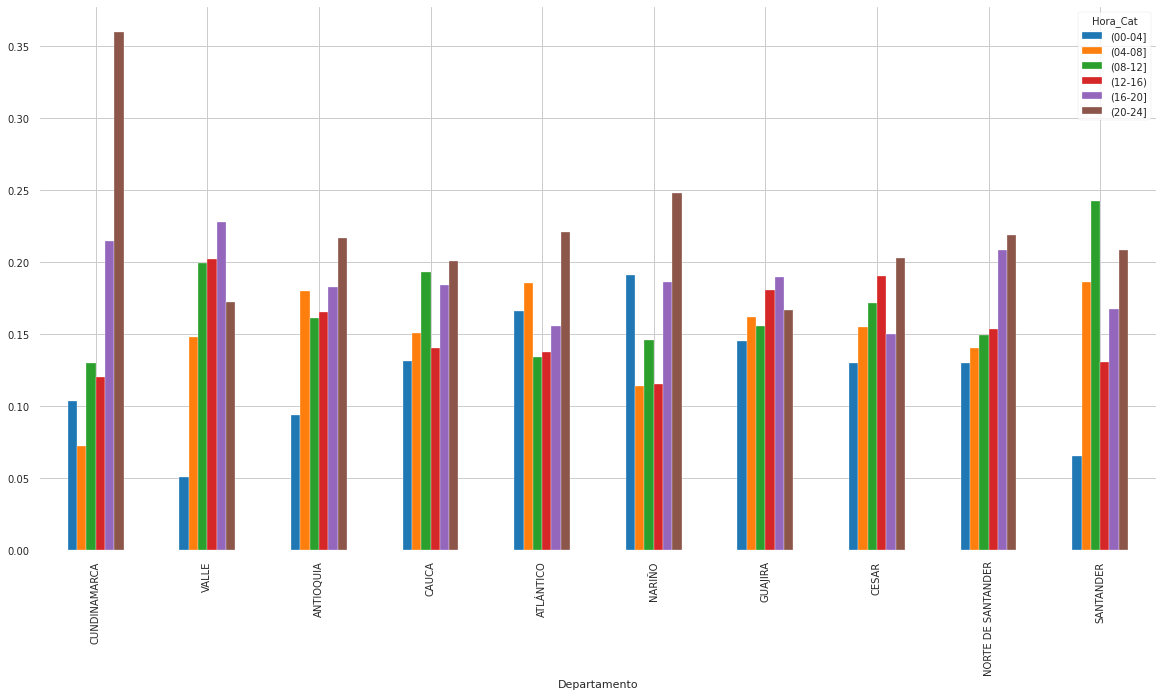

In [13]:
df_hurtos_cross_div.plot(kind='bar',figsize=(20,10),legend=True)

In [14]:
chi2, p, dof, ex =chi2_contingency(df_hurtos_hora_detartamento_c)

if (p < 0.05):
    print('La hora del robo de un vehiculo puede tener relacion con el departamento donde se comete el delito')
    print(p)

La hora del robo de un vehiculo puede tener relacion con el departamento donde se comete el delito
0.0


In [15]:
# Hora VS Arma Empleada
df_hurtos_hora_arma_c = pd.crosstab(index=df_hurtos.Hora_Cat,columns=df_hurtos["Arma empleada"],margins=True)
df_hurtos_hora_arma_c

Arma empleada,-,ARMA BLANCA / CORTOPUNZANTE,ARMA DE FUEGO,CONTUNDENTES,ESCOPOLAMINA,JERINGA,LLAVE MAESTRA,NO REPORTADO,SIN EMPLEO DE ARMAS,All
Hora_Cat,,,,,,,,,,
(00-04],1,81,761,22,54,0,1811,163,796,3689
(04-08],1,44,768,24,33,0,2643,137,853,4503
(08-12],0,51,1094,21,79,0,3202,144,1162,5753
(12-16),2,69,1241,32,106,0,2994,134,945,5523
(16-20],2,83,1966,42,54,0,4255,169,877,7448
(20-24],5,200,3434,46,45,1,3636,516,1748,9631
All,11,528,9264,187,371,1,18541,1263,6381,36547


<AxesSubplot:xlabel='Hora_Cat'>

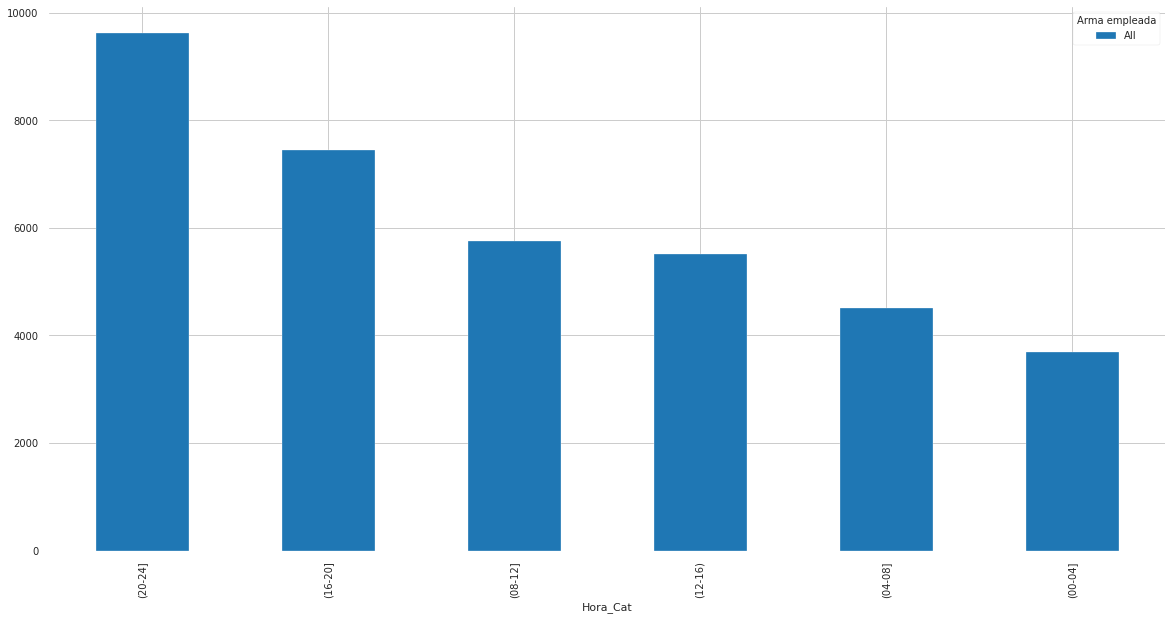

In [16]:
df_hurtos_hora_arma = df_hurtos_hora_arma_c.sort_values("All", ascending=False)
df_hurtos_hora_arma[["All"]].drop('All', axis=0).plot(kind='bar',figsize=(20,10))

In [17]:
df_hurtos_hora_arma = df_hurtos_hora_arma.div(df_hurtos_hora_arma.All, axis=0)
df_hurtos_hora_arma = df_hurtos_hora_arma.drop(['All'], axis=1).drop('All', axis=0)

<AxesSubplot:xlabel='Hora_Cat'>

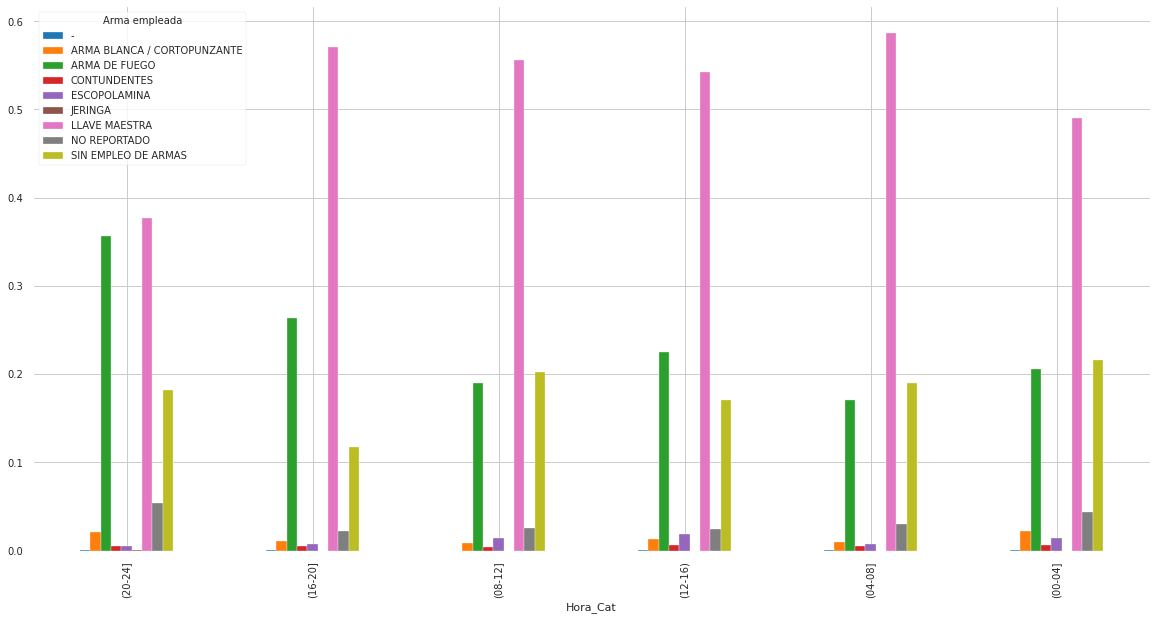

In [18]:
df_hurtos_hora_arma.plot(kind='bar',figsize=(20,10),legend=True)

In [19]:
chi2, p, dof, ex =chi2_contingency(df_hurtos_hora_arma_c)

if (p < 0.05):
    print('La hora del robo de un vehiculo puede tener relacion con el arma utilizada')
    print(p)

La hora del robo de un vehiculo puede tener relacion con el arma utilizada
0.0


In [20]:
# Hora, Sitio
df_hurtos_hora_sitio_c = pd.crosstab(index=df_hurtos["Clase de sitio"],columns=df_hurtos["Hora_Cat"],margins=True)
df_hurtos_hora_sitio_top = df_hurtos_hora_sitio_c.sort_values("All", ascending=False).head(15)
df_hurtos_hora_sitio_top

Hora_Cat,(00-04],(04-08],(08-12],(12-16),(16-20],(20-24],All
Clase de sitio,,,,,,,
All,3689,4503,5753,5523,7448,9631,36547
VIAS PUBLICAS,2785,3166,4341,4204,5814,7556,27866
PARQUEADERO,138,188,300,249,265,420,1560
FRENTE A RESIDENCIAS - VIA PUBLICA,232,369,179,140,196,283,1399
CARRETERA,76,146,160,191,225,192,990
FRENTE A RESIDENCIAS NO REPORTADA VIA PUBLICA,57,129,66,55,69,94,470
BAHIA,28,59,68,85,124,89,453
FINCAS Y SIMILARES,46,57,74,71,119,85,452
CASAS DE HABITACION,58,37,61,44,84,104,388


In [24]:
chi2, p, dof, ex =chi2_contingency(df_hurtos_hora_sitio_c)

if (p < 0.05):
    print('La hora del robo de un vehiculo puede tener relacion con el sitio')
    print(p)

La hora del robo de un vehiculo puede tener relacion con el sitio
6.595576950789246e-129


In [22]:
# Arma, Sitio
df_hurtos_arma_sitio_c = pd.crosstab(index=df_hurtos["Arma empleada"],columns=df_hurtos["Clase de sitio"],margins=True)
df_hurtos_arma_sitio_top = df_hurtos_arma_sitio_c.sort_values("All", ascending=False).head(15)
df_hurtos_arma_sitio_top

Clase de sitio,-,AEROPUERTO,ALIMENTADOR BUS M.I.O.,ALIMENTADOR BUS TRANSMILENIO,ALMACENES,ALOJAMIENTO,APARTAMENTO,APARTAMENTO EN CONJUNTO CERRADO,BAHIA,BANCOS,...,VEHICULO,VEHICULO BEAT,VEHICULO TAXI,VEHICULO UBER,VIAS PUBLICAS,ZONA DE PARQUEO,ZONA SELVÁTICA,ZONAS AZULES - VIA PUBLICA,ZONAS AZULES NO REPORTADA VIA PUBLICA,All
Arma empleada,,,,,,,,,,,,,,,,,,,,,
All,13,3,1,1,17,2,20,29,453,1,...,38,2,10,3,27866,84,6,4,1,36547
LLAVE MAESTRA,2,0,0,1,5,1,7,8,393,0,...,7,0,2,0,15056,48,0,2,0,18541
ARMA DE FUEGO,3,2,0,0,2,0,2,4,7,0,...,19,1,2,1,6754,2,3,1,1,9264
SIN EMPLEO DE ARMAS,7,0,1,0,10,1,11,15,41,1,...,9,0,1,0,4274,18,2,1,0,6381
NO REPORTADO,0,0,0,0,0,0,0,2,4,0,...,0,0,0,0,938,16,1,0,0,1263
ARMA BLANCA / CORTOPUNZANTE,1,0,0,0,0,0,0,0,2,0,...,3,1,3,2,404,0,0,0,0,528
ESCOPOLAMINA,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,311,0,0,0,0,371
CONTUNDENTES,0,1,0,0,0,0,0,0,5,0,...,0,0,1,0,121,0,0,0,0,187
-,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,7,0,0,0,0,11


In [25]:
chi2, p, dof, ex =chi2_contingency(df_hurtos_arma_sitio_c)

if (p < 0.05):
    print('El arma utilizada para el robo de un vehiculo puede tener relacion con el sitio')
    print(p)

El arma utilizada para el robo de un vehiculo puede tener relacion con el sitio
0.0
